In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import uuid
import os

import mlflow
from mlflow.tracking import MlflowClient
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
import numpy as np
import boto3

from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

# Read & Explore Data

* 2012-2015: Train
* 2016: Dev
* 2017: Monitoring 1
* 2018: Monitoring 2

### Read Data

In [2]:
raw_data = pd.read_csv(
    './data/raw/Metro_Interstate_Traffic_Volume_2012_2016.csv'
)

print(raw_data.dtypes)
raw_data

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
29645,NaN,267.29,0.0,0.0,1,Clear,sky is clear,2016-12-31 19:00:00,3974
29646,NaN,267.36,0.0,0.0,75,Clouds,broken clouds,2016-12-31 20:00:00,4490
29647,NaN,268.22,0.0,0.0,90,Clouds,overcast clouds,2016-12-31 21:00:00,2921
29648,NaN,268.90,0.0,0.0,75,Clouds,broken clouds,2016-12-31 22:00:00,2557


In [3]:
raw_data['date_time'] = pd.to_datetime(
    raw_data['date_time']
)

### Explore Data

In [4]:
exploration_data = raw_data.copy()

In [5]:
exploration_data['year'] = exploration_data['date_time'].dt.year
result = exploration_data.groupby('year')['date_time'].agg(['max', 'min', 'count']).reset_index()
print(result)
print("========================================================")
exploration_data['hour'] = exploration_data['date_time'].dt.hour
result = exploration_data.groupby('year')['hour'].agg(['max', 'min', 'count']).reset_index()
print(result)
print("========================================================")
exploration_data['month'] = exploration_data['date_time'].dt.month
result = exploration_data.groupby('year')['month'].agg(['max', 'min', 'count']).reset_index()
print(result)

   year                 max                 min  count
0  2012 2012-12-31 23:00:00 2012-10-02 09:00:00   2559
1  2013 2013-12-31 23:00:00 2013-01-01 00:00:00   8573
2  2014 2014-08-08 01:00:00 2014-01-01 00:00:00   4839
3  2015 2015-12-31 23:00:00 2015-06-11 20:00:00   4373
4  2016 2016-12-31 23:00:00 2016-01-01 00:00:00   9306
   year  max  min  count
0  2012   23    0   2559
1  2013   23    0   8573
2  2014   23    0   4839
3  2015   23    0   4373
4  2016   23    0   9306
   year  max  min  count
0  2012   12   10   2559
1  2013   12    1   8573
2  2014    8    1   4839
3  2015   12    6   4373
4  2016   12    1   9306


In [6]:
# date_time column contains duplicates:
# duplicates won't affect the process
exploration_data[exploration_data.duplicated('date_time', keep=False)]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,year,hour,month
178,NaN,281.25,0.0,0.0,99,Rain,light rain,2012-10-10 07:00:00,6793,2012,7,10
179,NaN,281.25,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 07:00:00,6793,2012,7,10
180,NaN,280.10,0.0,0.0,99,Rain,light rain,2012-10-10 08:00:00,6283,2012,8,10
181,NaN,280.10,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 08:00:00,6283,2012,8,10
182,NaN,279.61,0.0,0.0,99,Rain,light rain,2012-10-10 09:00:00,5680,2012,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...
29503,Christmas Day,276.08,0.0,0.0,90,Rain,light rain,2016-12-26 00:00:00,732,2016,0,12
29504,Christmas Day,276.08,0.0,0.0,90,Mist,mist,2016-12-26 00:00:00,732,2016,0,12
29516,NaN,266.93,0.0,0.0,90,Snow,light snow,2016-12-26 12:00:00,3374,2016,12,12
29517,NaN,266.93,0.0,0.0,90,Haze,haze,2016-12-26 12:00:00,3374,2016,12,12


#### DISTRIBUTIONS

In [7]:
def plot_box_plots(
    df,
    cat_col,
    num_col,
    year_col,
    datetime_col,
):
    
    unique_years = df[year_col].unique()
    num_years = len(unique_years)
    sorted_categories = sorted(df[cat_col].unique())
    
    # Set up the figure and axes for the subplots
    fig, axes = plt.subplots(nrows=(num_years + 1) // 2, ncols=2, figsize=(12, 6 * ((num_years + 1) // 2)))
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()
    
    for i, year in enumerate(unique_years):
        ax = axes[i]
        sns.boxplot(
            data=df[df[year_col] == year], 
            x=cat_col, 
            y=num_col, 
            ax=ax, 
            order=sorted_categories
        )
        ax.set_title(f'Year: {year}')
        ax.set_xlabel(cat_col)
        ax.set_ylabel(num_col)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

##### WEATHER DISTRIBUTION

weather_main
Clouds          10152
Clear            8028
Rain             3558
Mist             3480
Snow             1776
Drizzle           917
Haze              740
Thunderstorm      497
Fog               481
Smoke              17
Squall              4
Name: count, dtype: int64


/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

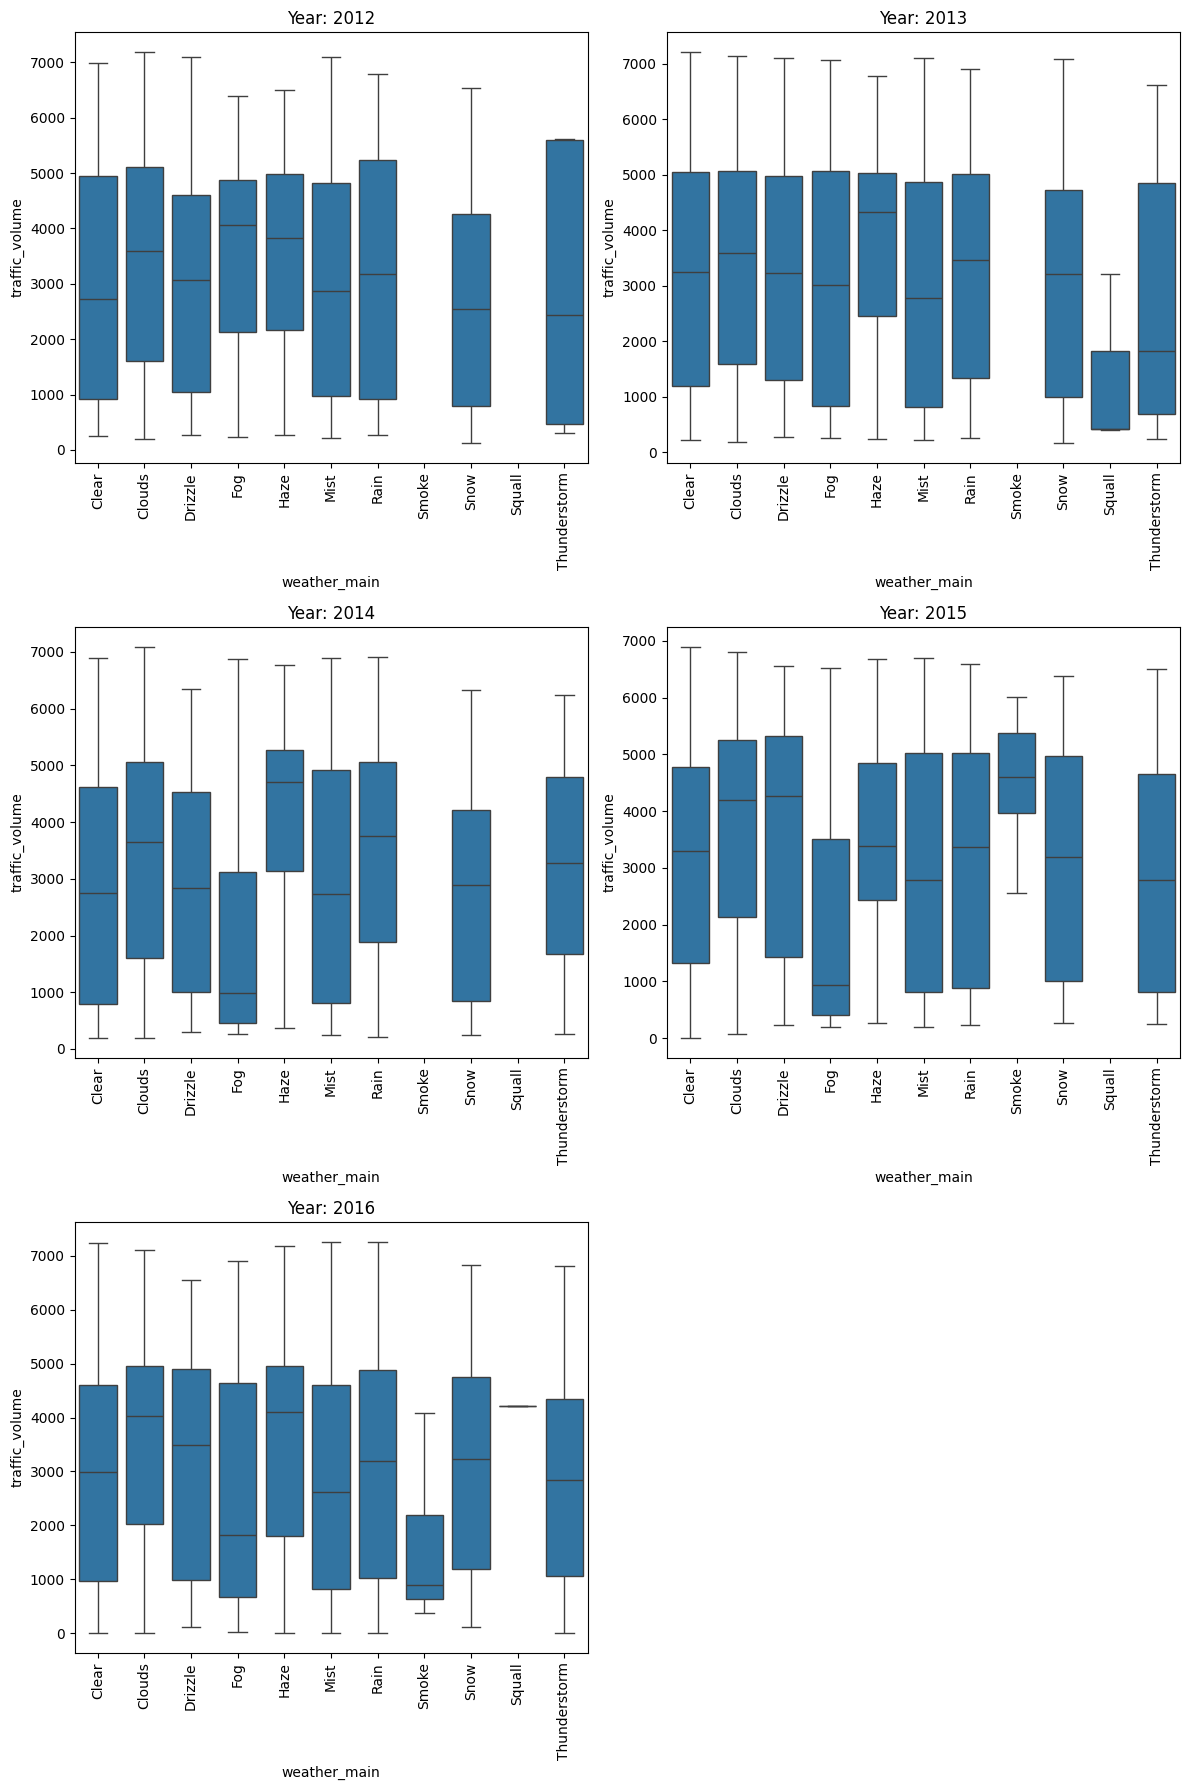

In [8]:
print(exploration_data['weather_main'].value_counts())

plot_box_plots(
    exploration_data,
    "weather_main",
    "traffic_volume",
    "year",
    "date_time",
)

##### HOUR DISTRIBTION

/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

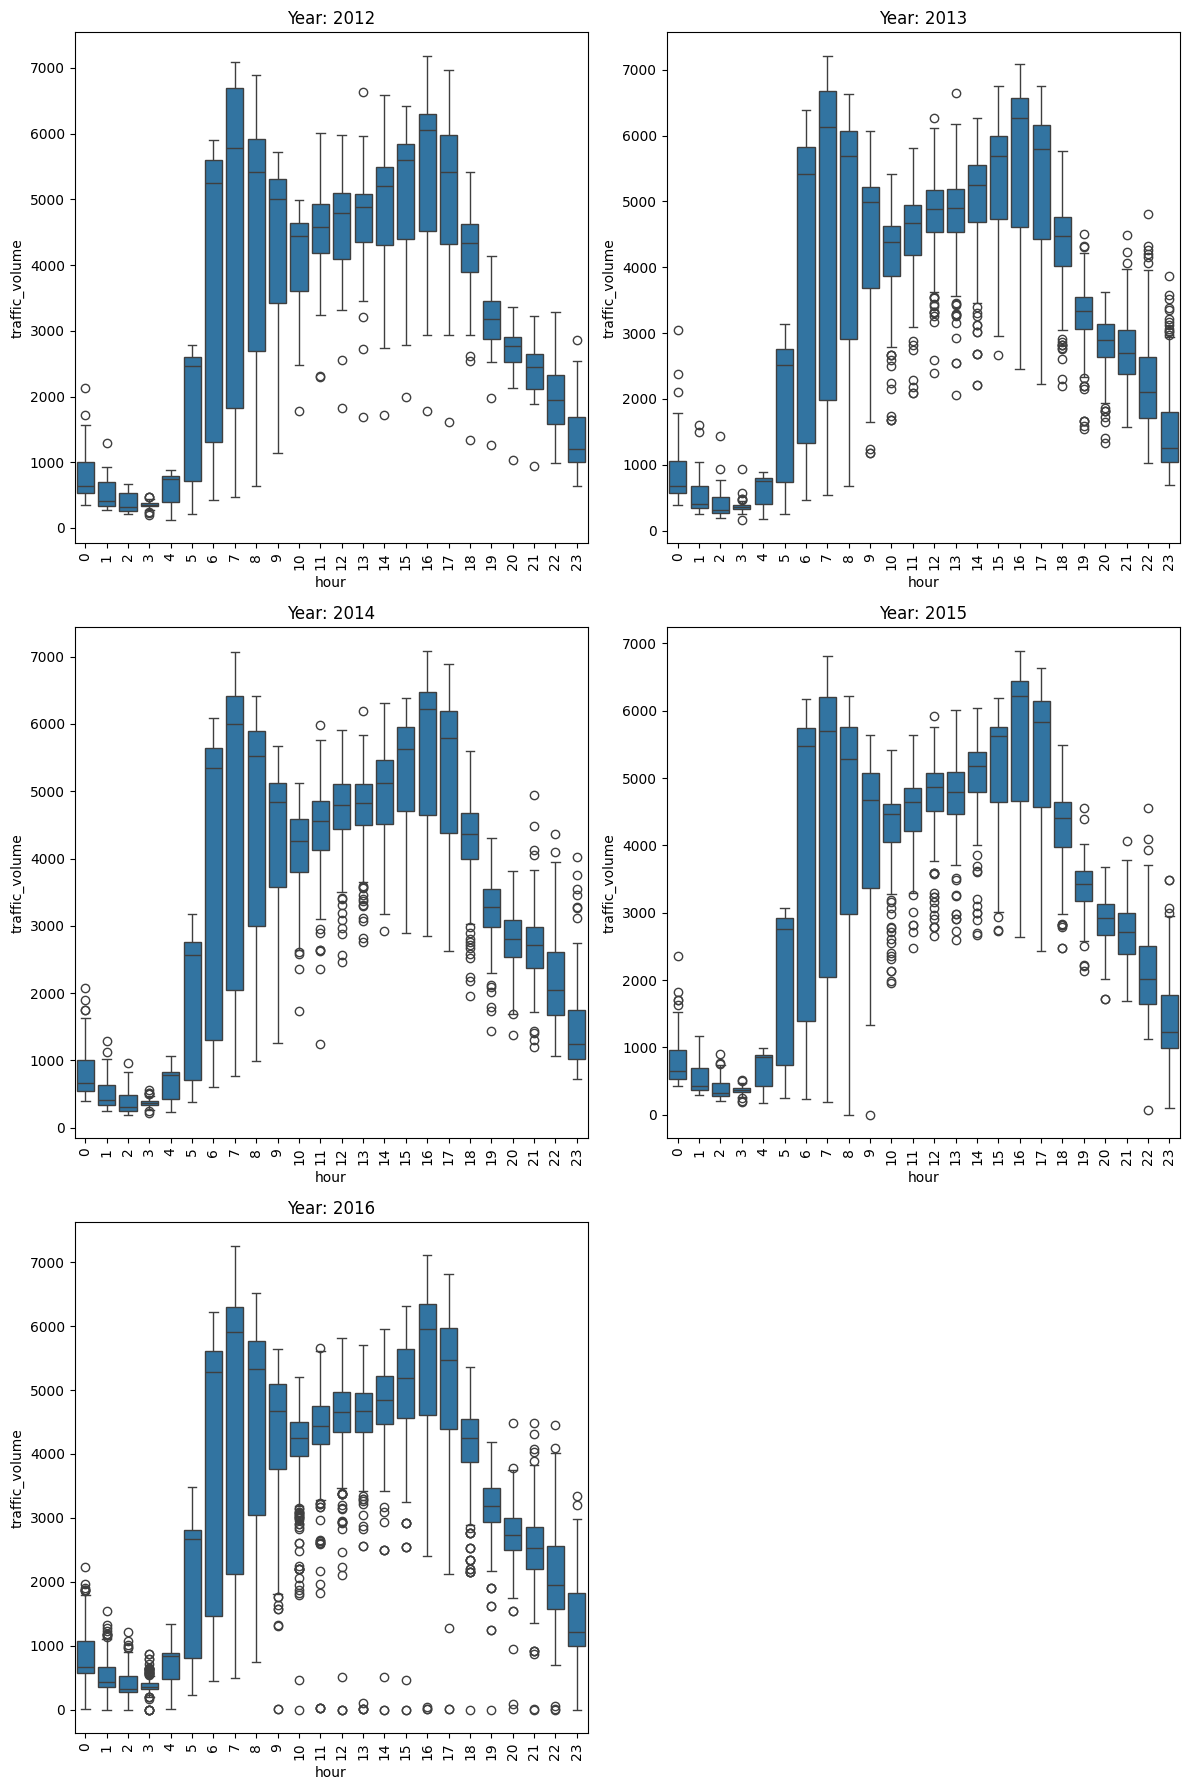

In [9]:
plot_box_plots(
    exploration_data,
    "hour",
    "traffic_volume",
    "year",
    "date_time",
)

##### MONTH DISTRIBUTION

/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

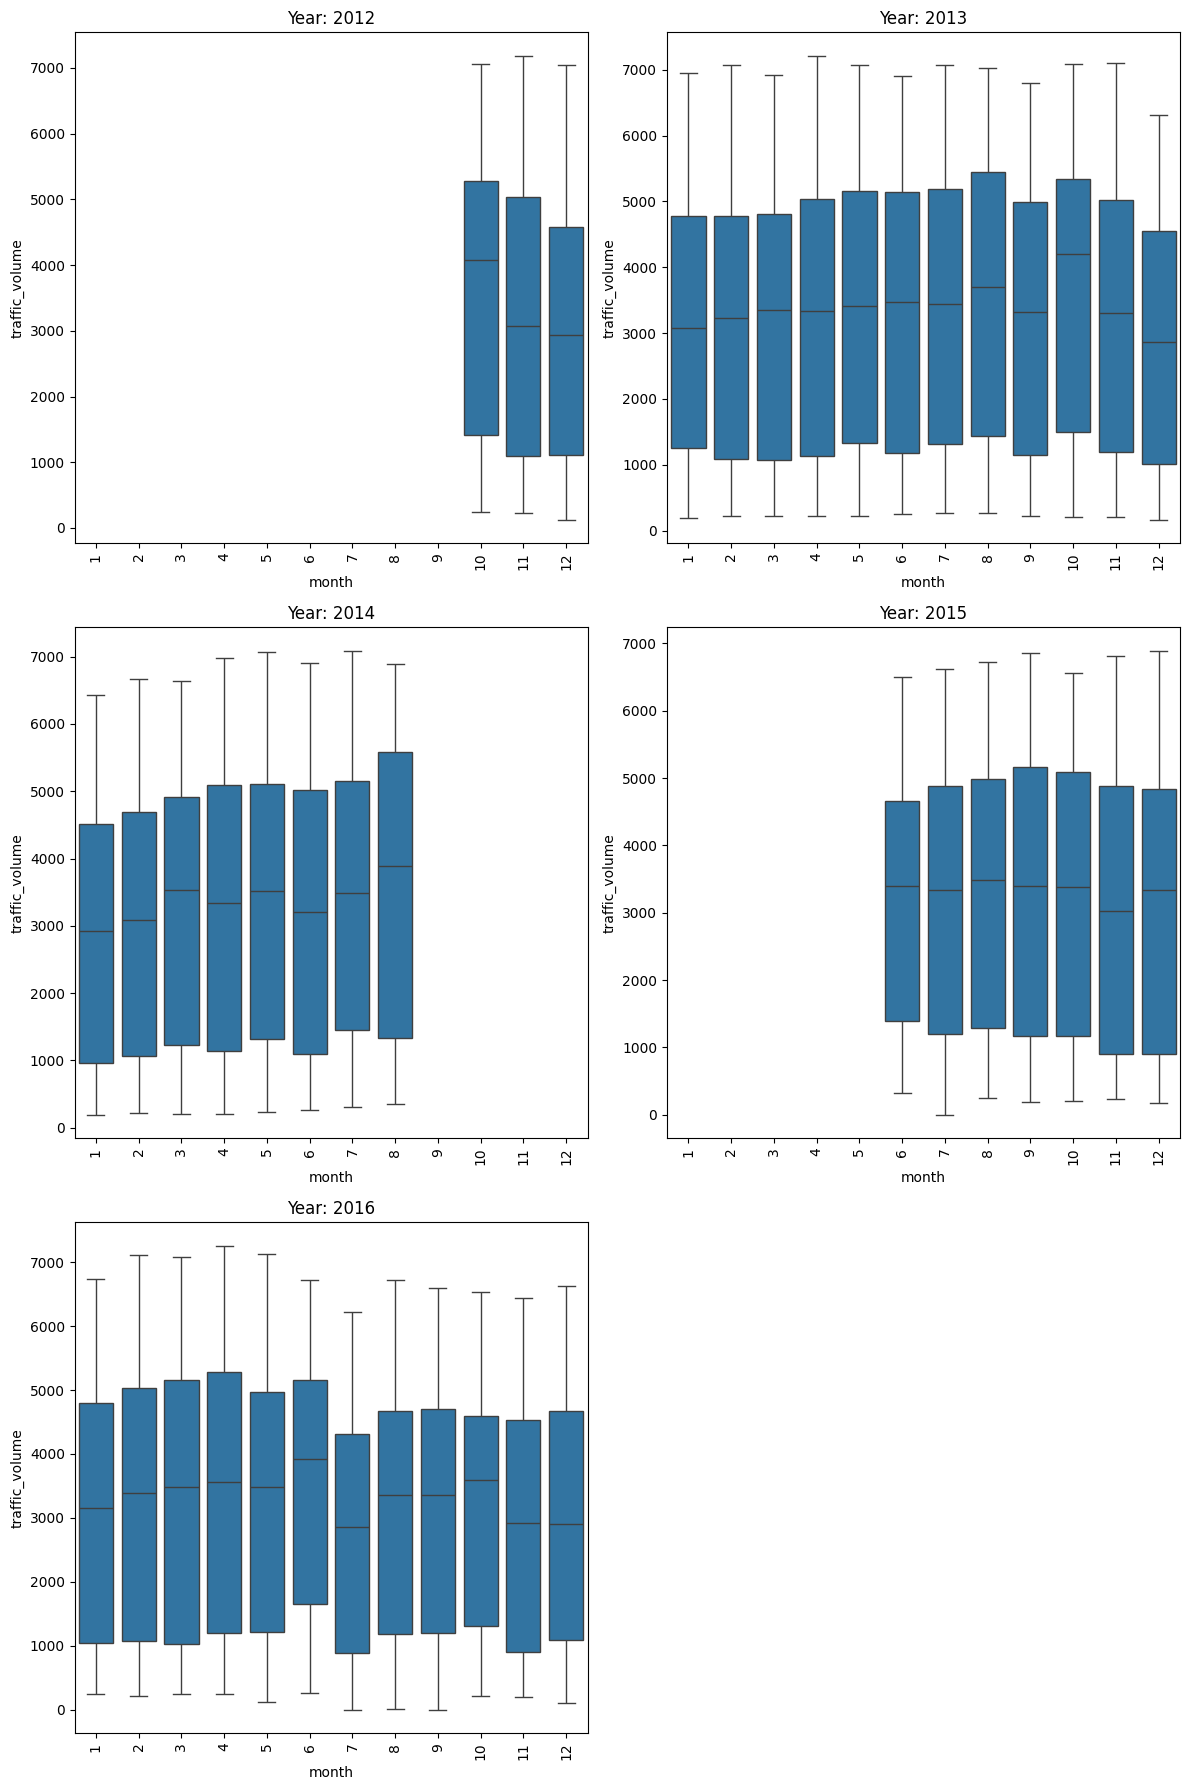

In [10]:
plot_box_plots(
    exploration_data,
    "month",
    "traffic_volume",
    "year",
    "date_time",
)

##### HOLIDAY DISTRIBUTION

In [11]:
exploration_data.holiday.fillna("NONE", inplace=True)
exploration_data.holiday.value_counts()

/tmp/ipykernel_5303/2740298907.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  exploration_data.holiday.fillna("NONE", inplace=True)


holiday
NONE                         29611
Thanksgiving Day                 5
Christmas Day                    5
Columbus Day                     4
Veterans Day                     4
New Years Day                    4
Labor Day                        4
Washingtons Birthday             3
Memorial Day                     3
Independence Day                 3
State Fair                       3
Martin Luther King Jr Day        1
Name: count, dtype: int64

/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_5303/386327018.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

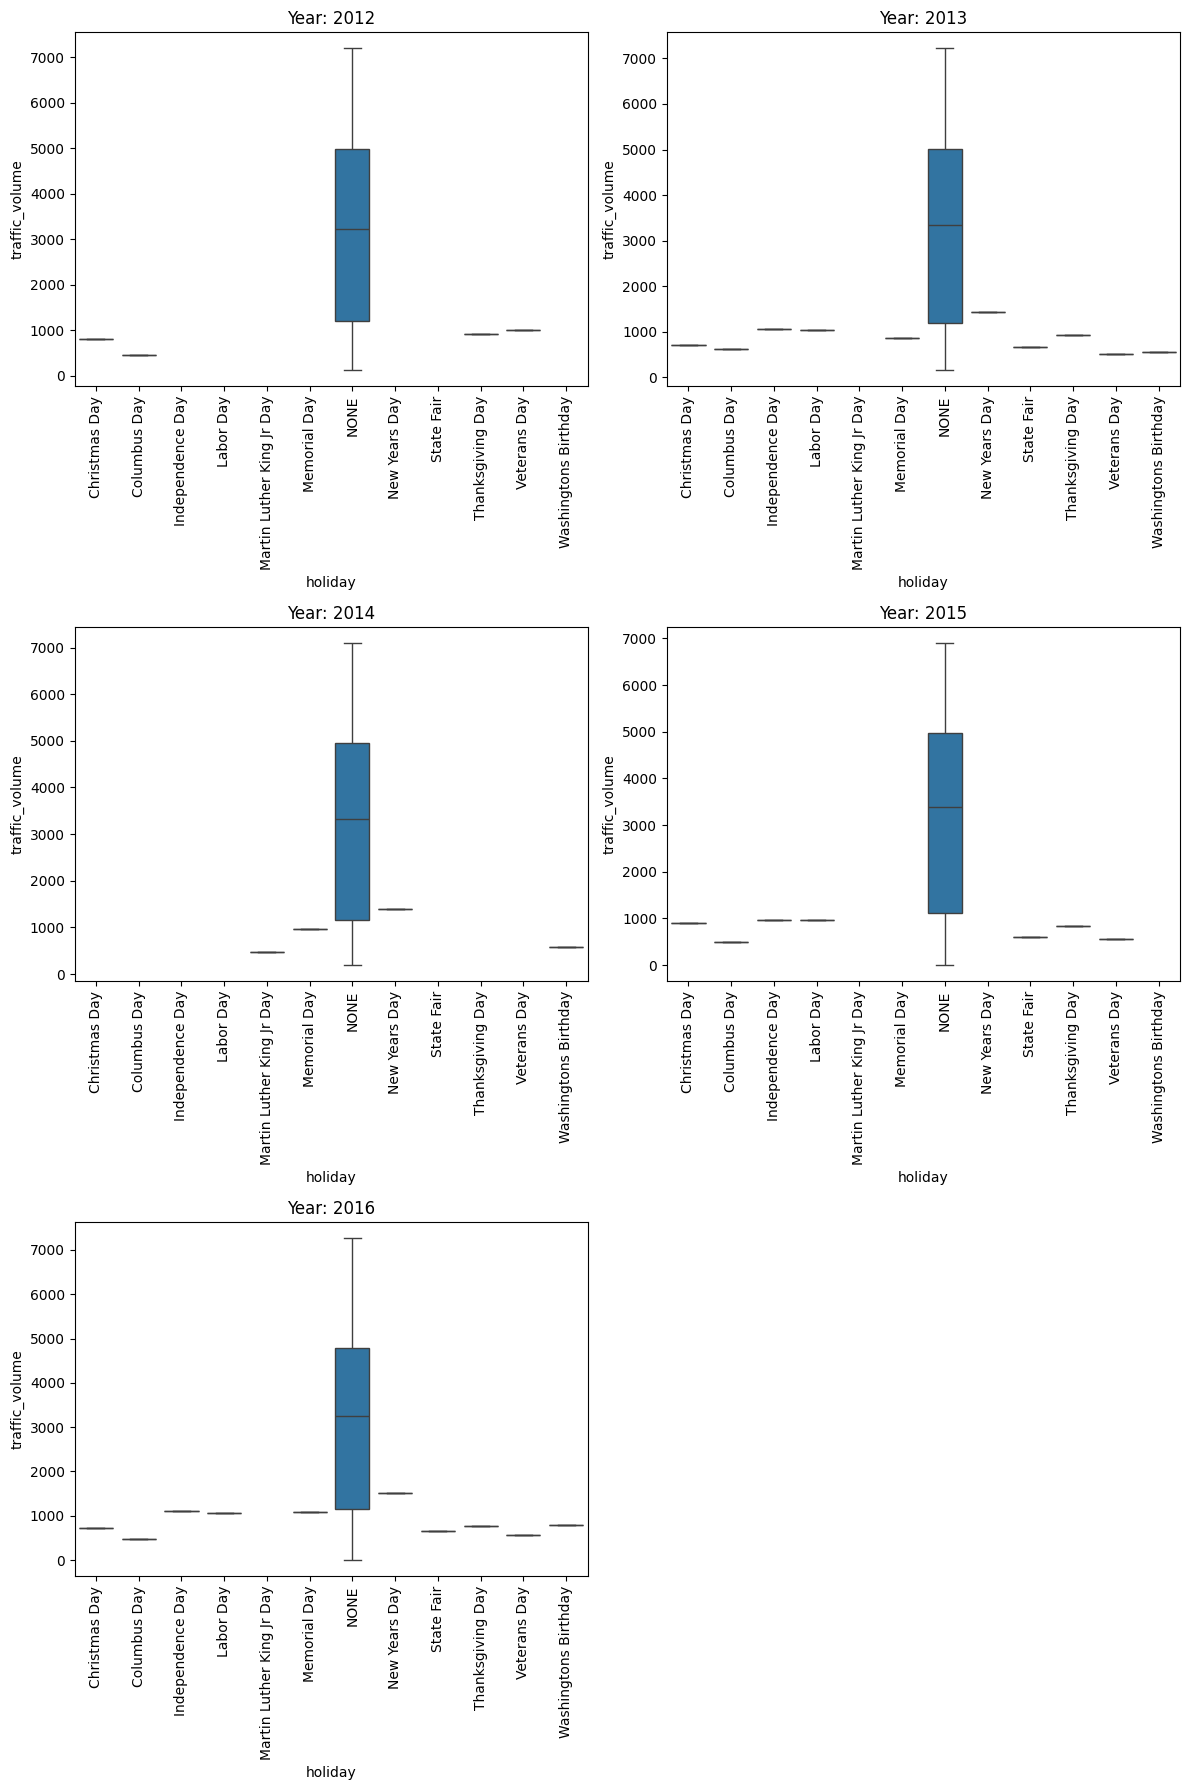

In [12]:
plot_box_plots(
    exploration_data,
    "holiday",
    "traffic_volume",
    "year",
    "date_time",
)

#### REMOVE EXPLORATION_DATA

In [13]:
del exploration_data

# Train-Dev Split

In [4]:
columns_to_keep = [
    'holiday', 'temp', 'rain_1h', 'snow_1h', 
    'clouds_all', 'weather_main'
]
target = "traffic_volume"

In [5]:
# Generate a namespace UUID dynamically based on column names
namespace_uuid = uuid.uuid5(uuid.NAMESPACE_DNS, ''.join(columns_to_keep + [target, "date_time"]))


In [6]:
type(namespace_uuid)

uuid.UUID

In [7]:
# Generate a namespace UUID dynamically based on column names
namespace_uuid = uuid.uuid5(uuid.NAMESPACE_DNS, ''.join(columns_to_keep + [target, "date_time"]))

# Function to generate a UUID based on row values
def generate_uuid(row):
    row_str = ','.join(map(str, row.values))
    return uuid.uuid5(namespace_uuid, row_str)

# Add a new column with UUIDs based on row values
raw_data['uuid'] = raw_data.apply(generate_uuid, axis=1)

In [8]:
train_data = raw_data[
    (raw_data['date_time'].apply(lambda x: x.year) < 2016)
].copy()
X_train = train_data[
    ["date_time"] + columns_to_keep
]
y_train = train_data[
    target
]

dev_data = raw_data[
    (raw_data['date_time'].apply(lambda x: x.year) == 2016)
].copy()
X_dev = dev_data[
    ["date_time"] + columns_to_keep
]
y_dev = dev_data[
    target
]

# Feature Engineering

In [9]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Fit the transformer if necessary
        return self

    def transform(self, X, y=None):
        # Apply transformation
        X_transformed = X.copy()
        
        # Perform Feature engineering
        X_transformed['hour'] = X_transformed['date_time'].dt.hour
        X_transformed['month'] = X_transformed['date_time'].dt.month

        # Transform holiday column to binary
        X_transformed['holiday'] = X_transformed['holiday'].map(
            lambda x: 0 if str(x) == 'nan' else 1
        )

        # weather_main rare values handling:
        X_transformed['weather_main'] = X_transformed['weather_main'].map(
            lambda x: "Fog_Smoke_Squall" if x in ["Fog", "Smoke", "Squall"] else x
        )

        # return xgb.DMatrix(
        #     X_transformed.drop("date_time", axis=1), 
        #     label=y
        # ) 
        return X_transformed.drop("date_time", axis=1)


class DictVectorizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse=False):
        self.sparse = sparse
        self.vectorizer = DictVectorizer(sparse=self.sparse)

    def fit(self, X, y=None):
        self.vectorizer.fit(X[['weather_main']].to_dict(orient='records'))
        return self

    def transform(self, X, y=None):
        
        weather_main_transformed = self.vectorizer.transform(X[['weather_main']].to_dict(orient='records'))
        weather_main_df = pd.DataFrame(weather_main_transformed, 
                                       columns=self.vectorizer.get_feature_names_out(), 
                                       index=X.index)
        X_transformed = X.join(weather_main_df).drop(columns=['weather_main'])
        return X_transformed

# Modeling

## Base Model

In [10]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('vectorizer', DictVectorizerTransformer(False)),
    ('regressor', XGBRegressor(
        objective='reg:squarederror'
    ))
])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering', FeatureEngineeringTransformer()),
                ('vectorizer', DictVectorizerTransformer()),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=Non..._policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [11]:
np.sqrt(
    mean_squared_error(
        pipeline.predict(X_dev), y_dev
    )
)

1024.9297089787005

## HyperOpt

In [24]:
# Define the objective function
def objective(space):
    model = XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        objective='reg:squarederror'
    )
    
    pipeline = Pipeline(steps=[
        ('feature_engineering', FeatureEngineeringTransformer()),
        ('vectorizer', DictVectorizerTransformer(False)),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)fabled mystic
    preds = pipeline.predict(X_dev)
    rmse = np.sqrt(mean_squared_error(y_dev, preds))
    
    return {'loss': rmse, 'status': STATUS_OK}

# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 0),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 0)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best hyperparameters:", best)


100%|████████| 100/100 [00:38<00:00,  2.58trial/s, best loss: 959.6026242463757]
Best hyperparameters: {'colsample_bytree': 0.6492679352018278, 'gamma': 0.06228934751252471, 'learning_rate': 0.050068277867324026, 'max_depth': 3.0, 'n_estimators': 150.0, 'reg_alpha': 0.09498601896489371, 'reg_lambda': 0.698292637697365, 'subsample': 0.7111528493489981}


## Best Model

In [28]:
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])

pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('vectorizer', DictVectorizerTransformer(False)),
    ('regressor', XGBRegressor(
        **best
    ))
])


pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering', FeatureEngineeringTransformer()),
                ('vectorizer', DictVectorizerTransformer()),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.6492679352018278, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              fea...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.050068277867324026, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=150, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [32]:
print(
    "DEV MSE:",
    np.sqrt(
        mean_squared_error(
            y_dev, pipeline.predict(X_dev)
        )
    )
)

print(
    "TRAINING MSE:",
    np.sqrt(
        mean_squared_error(
            y_train, pipeline.predict(X_train)
        )
    )
)

DEV RMSE: 959.6026242463757
TRAINING RMSE: 939.3314828125447


## Local Experiment Tracking with MLFLOW

In [46]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("traffic-volume-prediction")

2024/07/02 14:11:35 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/07/02 14:11:35 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade acf3f17fdcc7 -> 867495a8f9d4, add trace tables
INFO  [alembic.runtime.migration] Running upgrade 867495a8f9d4 -> 5b0e9adcef9c, add cascade deletion to trace tables foreign keys
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2024/07/02 14:11:37 INFO mlflow.tracking.fluent: Experiment with name 'traffic-volume-prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='/media/mohammed/workspace3/__ing/mlopsing/MLOps-traffic-volume-prediction/mlruns/1', creation_time=1719918697038, experiment_id='1', last_update_time=1719918697038, lifecycle_stage='active', name='traffic-volume-prediction', tags={}>

In [48]:
# Track the top 3 models
best_models = []

# Define the objective function
def objective(space):
    model = XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        objective='reg:squarederror'
    )
    
    pipeline = Pipeline(steps=[
        ('feature_engineering', FeatureEngineeringTransformer()),
        ('vectorizer', DictVectorizerTransformer(False)),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_dev)
    rmse = np.sqrt(mean_squared_error(y_dev, preds))
    
    # Log parameters and metrics to MLflow
    with mlflow.start_run(nested=True):
        mlflow.log_params(space)
        mlflow.log_metric('rmse', rmse)
        
        # Save the model if it is one of the best
        if len(best_models) < 3:
            best_models.append((rmse, pipeline, space))
        else:
            worst_rmse = max(best_models, key=lambda x: x[0])[0]
            if rmse < worst_rmse:
                best_models.remove(max(best_models, key=lambda x: x[0]))
                best_models.append((rmse, pipeline, space))
    
    return {'loss': rmse, 'status': STATUS_OK}

# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 0),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 0)
}

# Run the optimization
trials = Trials()
with mlflow.start_run(run_name='hyperopt_xgb') as run:
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials)

# Log the top 3 models
for i, (rmse, pipeline, params) in enumerate(sorted(best_models, key=lambda x: x[0])):
    with mlflow.start_run(run_name=f'best_model_{i+1}', nested=True):
        mlflow.log_params(params)
        mlflow.log_metric('rmse', rmse)
        mlflow.sklearn.log_model(pipeline, artifact_path=f'model_{i+1}')

print("Best hyperparameters:", best)

100%|████████| 100/100 [01:25<00:00,  1.17trial/s, best loss: 958.9450790331019]


/home/mohammed/.local/share/virtualenvs/MLOps-traffic-volume-prediction-pQEbZpf7/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mohammed/.local/share/virtualenvs/MLOps-traffic-volume-prediction-pQEbZpf7/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best hyperparameters: {'colsample_bytree': 0.5496866518827618, 'gamma': 0.13458291937793912, 'learning_rate': 0.07879683775861811, 'max_depth': 4.0, 'n_estimators': 100.0, 'reg_alpha': 0.19475208641146496, 'reg_lambda': 0.2291311899740037, 'subsample': 0.760901032550237}


## AWS Experiment Tracking with MLFLOW

**Mlflow Setup:**
- Tracking Server: EC2
- Backend Store: Postgresql db
- Artifacts Store: s3 bucket

* cd /path/to/mlflow-key-pair.pem
* ssh -i "mlflow-key-pair.pem" ec2-user@`public_DNS_of_the_EC2_instance`

* sudo yum update

* sudo dnf install python3.11
* python3.11 -m ensurepip

* pip3.11 install mlflow boto3 psycopg2-binary
* aws configure # you'll need to input your AWS credentials here
* cat ~/.aws/* #CHECK
* mlflow server -h 0.0.0.0 -p 5000 --backend-store-uri postgresql://DB_USER:DB_PASSWORD@DB_ENDPOINT:5432/DB_NAME --default-artifact-root s3://S3_BUCKET_NAME


* #In a browser: http://`public_DNS_of_the_EC2_instance`:5000/

* #open another terminal and make sure that the aws profile is also created on your local machine
* ls ~/.aws
* #You should have `config` and `credentials` files

In [ ]:
os.environ["AWS_PROFILE"] = "default" # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials

TRACKING_SERVER_HOST = "ec2-13-53-40-66.eu-north-1.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

mlflow.set_experiment("traffic-volume-prediction")

<Experiment: artifact_location='s3://mlflow-artifacts-melhamamsy/1', creation_time=1720021760437, experiment_id='1', last_update_time=1720021760437, lifecycle_stage='active', name='traffic-volume-prediction', tags={}>

In [18]:
mlflow.search_experiments()

[<Experiment: artifact_location='s3://mlflow-artifacts-melhamamsy/1', creation_time=1720021760437, experiment_id='1', last_update_time=1720021760437, lifecycle_stage='active', name='traffic-volume-prediction', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifacts-melhamamsy/0', creation_time=1720021090744, experiment_id='0', last_update_time=1720021090744, lifecycle_stage='active', name='Default', tags={}>]

In [19]:
# Track the top 3 models
best_models = []

# Define the objective function
def objective(space):
    model = XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        objective='reg:squarederror'
    )
    
    pipeline = Pipeline(steps=[
        ('feature_engineering', FeatureEngineeringTransformer()),
        ('vectorizer', DictVectorizerTransformer(False)),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_dev)
    rmse = np.sqrt(mean_squared_error(y_dev, preds))
    
    # Log parameters and metrics to MLflow
    with mlflow.start_run(nested=True):
        mlflow.log_params(space)
        mlflow.log_metric('rmse', rmse)
        
        # Save the model if it is one of the best
        if len(best_models) < 3:
            best_models.append((rmse, pipeline, space))
        else:
            worst_rmse = max(best_models, key=lambda x: x[0])[0]
            if rmse < worst_rmse:
                best_models.remove(max(best_models, key=lambda x: x[0]))
                best_models.append((rmse, pipeline, space))
    
    return {'loss': rmse, 'status': STATUS_OK}

# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 0),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 0)
}

# Run the optimization
trials = Trials()
with mlflow.start_run(run_name='hyperopt_xgb') as run:
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=5,
                trials=trials)

# Log the top 3 models
for i, (rmse, pipeline, params) in enumerate(sorted(best_models, key=lambda x: x[0])):
    with mlflow.start_run(run_name=f'top_performing_models', nested=True):
        mlflow.log_params(params)
        mlflow.log_metric('rmse', rmse)
        mlflow.sklearn.log_model(pipeline, artifact_path=f'model_{i+1}')

print("Best hyperparameters:", best)

100%|███████████| 5/5 [00:07<00:00,  1.42s/trial, best loss: 1017.5147474734598]


/home/mohammed/.local/share/virtualenvs/MLOps-traffic-volume-prediction-pQEbZpf7/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mohammed/.local/share/virtualenvs/MLOps-traffic-volume-prediction-pQEbZpf7/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best hyperparameters: {'colsample_bytree': 0.5345413558243601, 'gamma': 0.7082985541763455, 'learning_rate': 0.1554344788423814, 'max_depth': 6.0, 'n_estimators': 200.0, 'reg_alpha': 0.05117717397689444, 'reg_lambda': 0.7558517806737054, 'subsample': 0.805324137526245}


## Interact with registered models

In [21]:
client = MlflowClient(f"http://{TRACKING_SERVER_HOST}:5000")

In [22]:
client.search_registered_models()

[]

In [34]:
client.search_runs(
    experiment_ids=['1'],
    filter_string = 'attribute.run_name = "best_model_1"'
)[0].info.run_id

'ab17ca13b8114147a5263d1471fbd1cb'

In [35]:
run_id = client.search_runs(
    experiment_ids=['1'],
    filter_string = 'attribute.run_name = "best_model_1"'
)[0].info.run_id

mlflow.register_model(
    model_uri=f"runs:/{run_id}/models",
    name='traffic_volume_predictor'
)

Successfully registered model 'traffic_volume_predictor'.
2024/07/03 19:43:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: traffic_volume_predictor, version 1
Created version '1' of model 'traffic_volume_predictor'.


<ModelVersion: aliases=[], creation_timestamp=1720025026733, current_stage='None', description='', last_updated_timestamp=1720025026733, name='traffic_volume_predictor', run_id='ab17ca13b8114147a5263d1471fbd1cb', run_link='', source='s3://mlflow-artifacts-melhamamsy/1/ab17ca13b8114147a5263d1471fbd1cb/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>

In [36]:
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1720025026106, description='', last_updated_timestamp=1720025026733, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1720025026733, current_stage='None', description='', last_updated_timestamp=1720025026733, name='traffic_volume_predictor', run_id='ab17ca13b8114147a5263d1471fbd1cb', run_link='', source='s3://mlflow-artifacts-melhamamsy/1/ab17ca13b8114147a5263d1471fbd1cb/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>], name='traffic_volume_predictor', tags={}>]

# SHAP

In [12]:
pipeline

Pipeline(steps=[('feature_engineering', FeatureEngineeringTransformer()),
                ('vectorizer', DictVectorizerTransformer()),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=Non..._policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [17]:
X_train

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main
0,2012-10-02 09:00:00,NaN,288.28,0.0,0.0,40,Clouds
1,2012-10-02 10:00:00,NaN,289.36,0.0,0.0,75,Clouds
2,2012-10-02 11:00:00,NaN,289.58,0.0,0.0,90,Clouds
3,2012-10-02 12:00:00,NaN,290.13,0.0,0.0,90,Clouds
4,2012-10-02 13:00:00,NaN,291.14,0.0,0.0,75,Clouds
...,...,...,...,...,...,...,...
20339,2015-12-31 15:00:00,NaN,264.83,0.0,0.0,90,Snow
20340,2015-12-31 16:00:00,NaN,264.89,0.0,0.0,90,Snow
20341,2015-12-31 19:00:00,NaN,265.32,0.0,0.0,90,Snow
20342,2015-12-31 21:00:00,NaN,265.51,0.0,0.0,75,Snow


In [21]:


#   ('feature_engineering', FeatureEngineeringTransformer()),
#     ('vectorizer', DictVectorizerTransformer(False)),
#     ('regressor', XGBRegressor(
#         objective='reg:squarederror'
#     ))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [39]:
from typing import Tuple, Dict
import base64
import io
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import shap

from pandas import Series, DataFrame
from sklearn import Pipeline

@render(render_type='jpeg')
def create_shap_visualization(
    inputs: Tuple[DataFrame, Dict[Pipeline]]
):
 
    
    x, pipelines = inputs
    x = x.drop(["date_time", "traffic_volume", "uuid"], axis=1)
    
    ## Shuffle df
    x = x.sample(frac=1).reset_index(drop=True)

    # Create a SHAP explainer based on the model and the data
    for version, pipeline in pipelines.items():
        print("\n"*5,"="*40, f" Plotting Shap Values for model with version {version} ", "="*40, sep="") 

        x = pipeline["feature_engineering"].transform(x)
        x = pipeline["vectorizer"].transform(x)

        explainer = shap.Explainer(
            pipeline["regressor"], x
        )
        shap_values = explainer(x)

        # Summary plot
        shap.summary_plot(shap_values, x)
        
        my_stringIObytes = io.BytesIO()
        plt.savefig(my_stringIObytes, format='jpg')
        my_stringIObytes.seek(0)
        my_base64_jpgData = base64.b64encode(my_stringIObytes.read()).d
        
        plt.close()
        return my_base64_jpgData
        

#         # Dependence plot for the first feature (you can loop through all features)
#         shap.dependence_plot(0, shap_values.values, x)

#         # Bar plot for feature importance
#         shap.plots.bar(shap_values)

#         # Decision plot for a subset of instances (optional)
#         shap.decision_plot(explainer.expected_value, shap_values.values[:50], x.iloc[:50])

        # Force plot for a specific instance (index 0 in this example)
        # shap.force_plot(explainer.expected_value, shap_values.values[0], x.iloc[0], matplotlib=True)
        # plt.show()

ImportError: cannot import name 'Pipeline' from 'sklearn' (/home/mohammed/.local/share/virtualenvs/MLOps-traffic-volume-prediction-pQEbZpf7/lib/python3.11/site-packages/sklearn/__init__.py)

<Axes: >

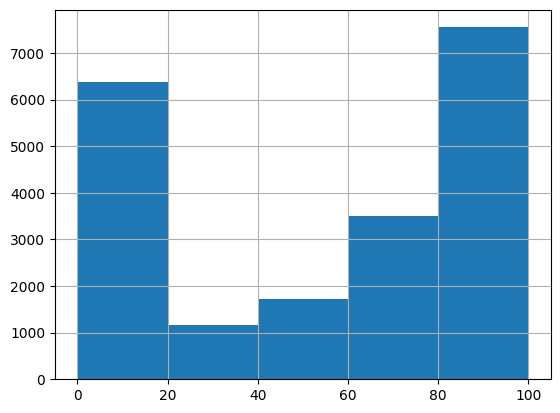

In [40]:
X_train["clouds_all"].hist(bins=5)